In [17]:
import matplotlib.pyplot as plt
import cyipopt as ipopt
import numpy as np

from vessel_models import VesselModel
from controller import MPC

In [ ]:
# Simulation variables
N = 100
dt = 0.1
ns = 6
nu = 3

N_mpc = 10 # default 10
N_sim = N + N_mpc

# Cost matrices
Qvec = 3*np.ones(ns) # default 3
Rvec = np.ones(nu)
Qfvec = 10*np.ones(ns)

# Reference trajectory
Sload = np.loadtxt('dircol_soln.csv', delimiter=',')
Sf = Sload[-1]
Sref = np.tile(Sf, (N_sim, 1))
Sref[:N] = Sload

# Obstacle States
num_obstacles = 2
obstacles = np.zeros((num_obstacles,3))
obstacles[0] = [0.25, 0.25, 0.1]
obstacles[1] = [0.75, 0.75, 0.1]

model = VesselModel(mismatch=False)
print(model.m)

23.8


In [19]:
U_soln = np.zeros((N-1, nu))
S_soln = np.zeros((N, ns))
S_soln[0] = Sref[0]

for i in range(N-1):
    s0 = S_soln[i]
    sf = Sref[i+N_mpc-1] # use for solving following a trajectory
    sref = Sref[i:i+N_mpc]
    trajoptimizer = MPC(model, N_mpc, ns, nu, dt, Qvec, Rvec, Qfvec, s0, sf, sref, obstacles)
    trajoptimizer.exec_MPC()
    S, U = trajoptimizer.flat2vec(trajoptimizer.sol.x)
    U_soln[i] = U[0]
    S_soln[i+1] = model.rk4(s0, U[0], dt)
    

Running MPC Solver Version: with_traj
Executed MPC Solver Version: with_traj
This is Ipopt version 3.14.17, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:     5742
Number of nonzeros in inequality constraint Jacobian.:     4698
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       87
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       66
Total number of inequality constraints...............:       54
        inequality constraints with only lower bounds:       54
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2

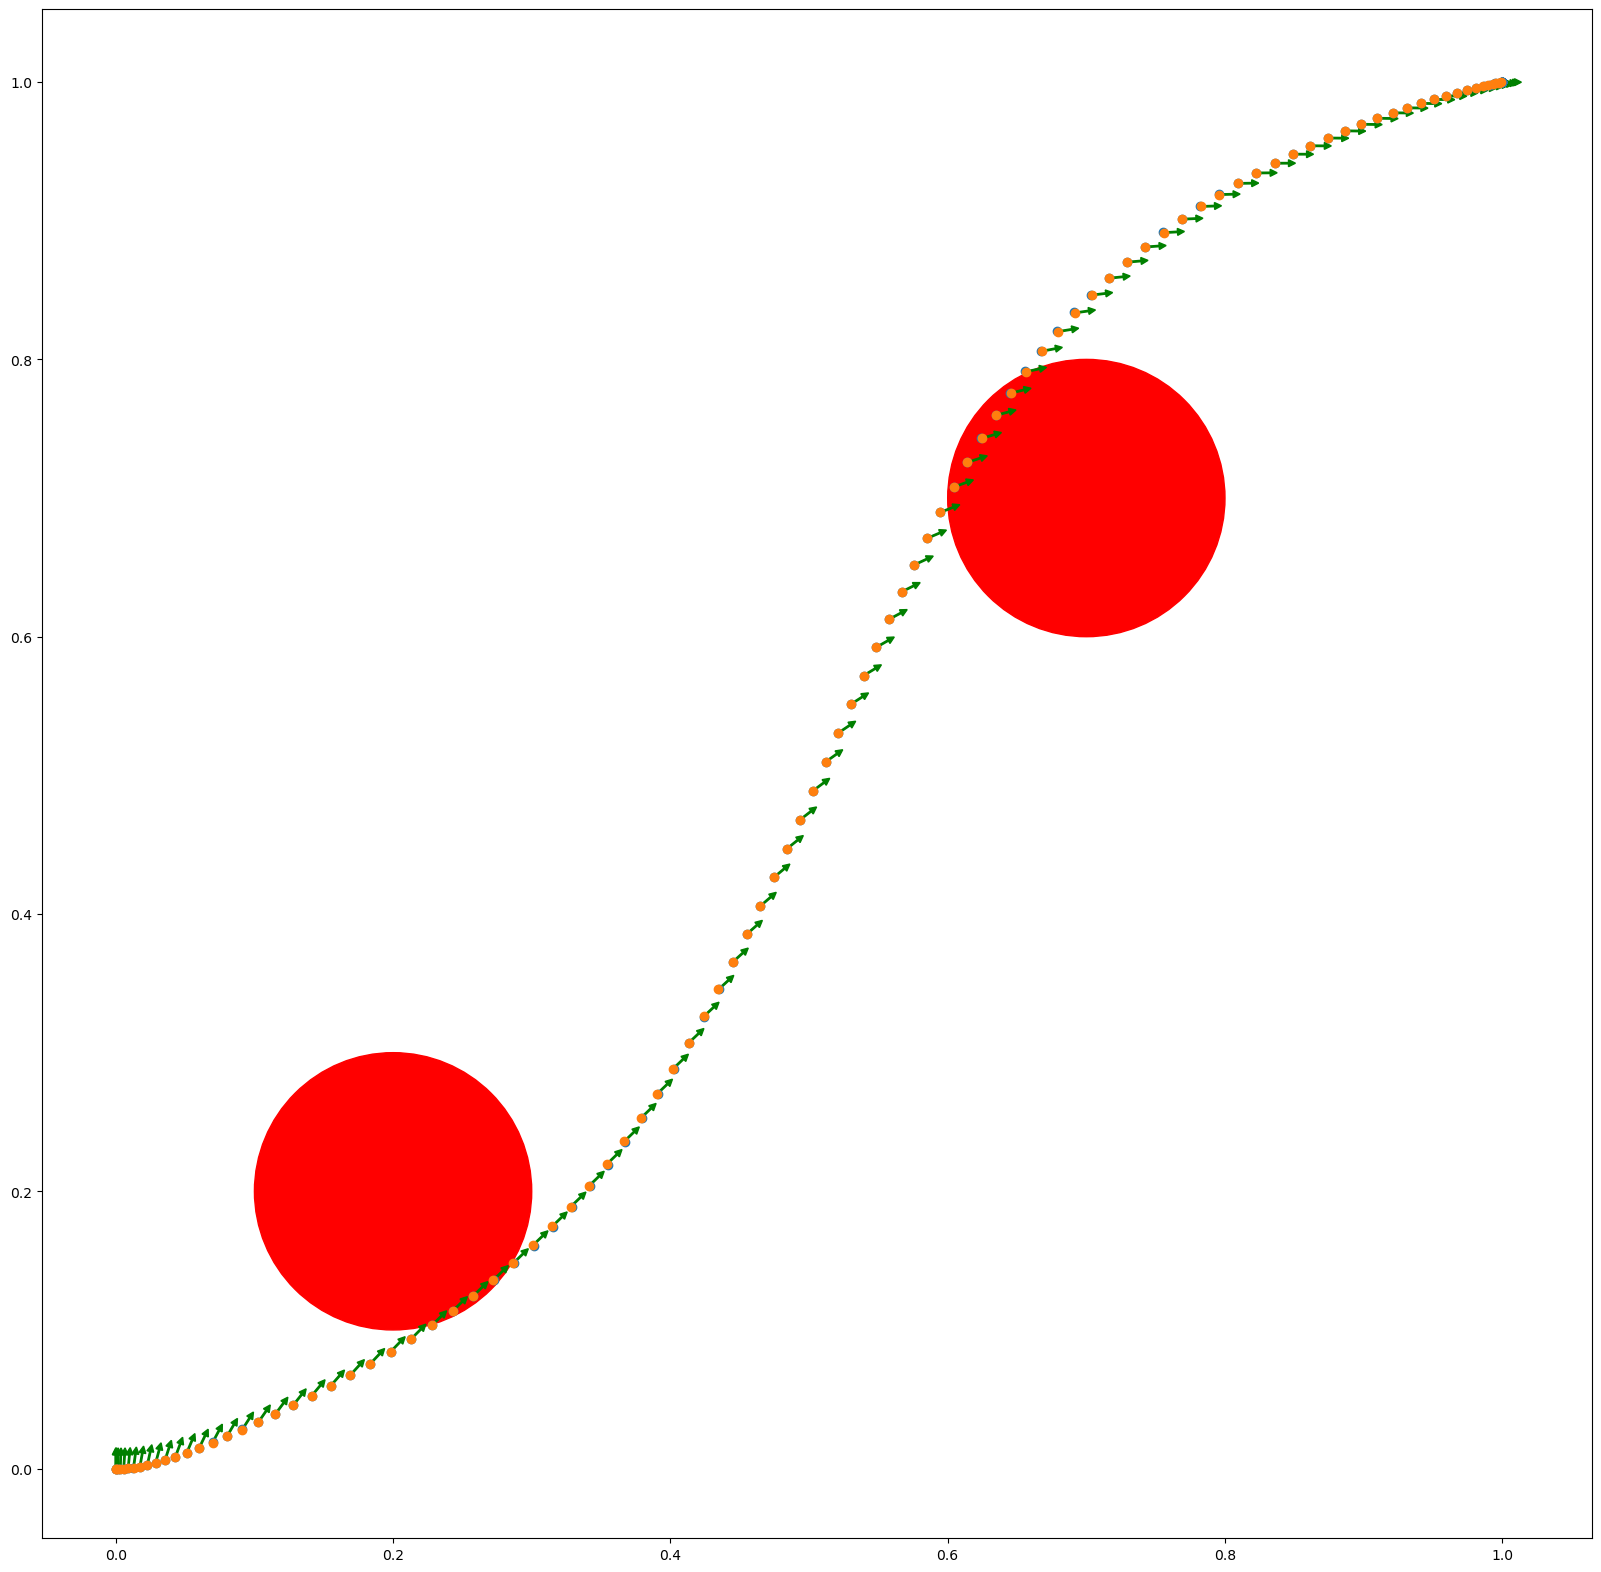

In [20]:
Sfwd = np.zeros((N,ns))
Sfwd[0] = Sref[0]
for i in range(N-1):
    Sn = Sfwd[i]
    Un = U_soln[i]
    Sfwd[i+1] = model.rk4(Sn, Un, dt)

#ps = Sfwd.T
ps = S_soln.T
ps_ref = Sref.T
fig, axes = plt.subplots(1, 1, figsize=(20, 20))

for obstacle in obstacles:
    obs_x, obs_y, obs_r = obstacle
    circle = plt.Circle((obs_y, obs_x), obs_r, color='r')
    axes.add_patch(circle)

for i in range(len(ps[1])):
    dx = 0.01*np.cos(ps[2,i])
    dy = 0.01*np.sin(ps[2,i])
    axes.arrow(ps[1,i], ps[0, i], dy, dx, head_width=0.005, head_length=0.005, fc='green', ec='green')
    
axes.scatter(ps_ref[1], ps_ref[0])
axes.scatter(ps[1], ps[0])
axes.set_aspect('equal', adjustable='box')
plt.show()